Welcome to machine learning project! It focuses on building a regression model to predict the prices of laptops based on their specifications. The data was collected data from a website and will use it to train a model where the independent variables are the laptop specs, and the dependent variable is the price. Our goal is to create a model that accurately predicts the price of a new laptop based on its specs. This will help businesses make informed decisions about pricing and inventory. We will explore, preprocess it, select a suitable regression model, train and evaluate the model, and fine-tune it to achieve the best results.


#Required Libraries


In [1]:
!pip install fuzzywuzzy
from fuzzywuzzy import fuzz
import requests
from bs4 import BeautifulSoup
import bs4
import csv
import time
from random import uniform
import numpy as np
import pandas as pd
import json
import seaborn as sns
from matplotlib import pyplot as plt
from pandas_profiling import ProfileReport
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks/Komputronik/Komputronik_prices
from notebook_scraper_pr import Notebook_Scraper

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.9/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/Komputronik/Komputronik_prices


In [ ]:
!git commit -am 'added counter'

[CPU_scraping 7aa8d54] added counter
 3 files changed, 5 insertions(+), 7159 deletions(-)
 rewrite Komputronik_prices.ipynb (65%)
 delete mode 100644 full_data.csv


# Notebook_Scraper class

In [ ]:
# import requests
# from bs4 import BeautifulSoup
# import csv
# import time
# from random import uniform
# import numpy as np

# class Notebook_Scraper:
#     """
#     A class representing a Notebook_Scraper object.
    
#     Methods:
#     - __init__(self, url: str): Initializes a new Notebook_Scraper object with the given url and full_details_list list.
#     - scrape(self): Get notebook details from self.url. Returns a list of dicts with notebook details.
#     - save_data(self, data: list): Saves the list of dicts with notebooks details to a file.
#     - open_data(self, data_csv_name_file)->list: Opens a csv file with dicts with notebooks details. Returns a list of dicts with notebooks details.
#     """

#     def __init__(self, url):
#         self.url = url
#         self.full_details_list = []

#     def scrape(self) ->list :
#         """
#         Get notebook details from self.url.

#         Returns:
#           List of dicts with notebook details.
#         """
#         response = requests.get(self.url)
#         content = response.content
#         soup = BeautifulSoup(content, 'html.parser')

#         self.last_page = int(soup.find_all('li', {
#             'class': 'flex justify-center items-center w-8 h-8 rounded border border-gray-mercury cursor-pointer'})[
#                             -1].get_text())

#         for page in range(1, self.last_page + 1):
#             url = f'https://www.komputronik.pl/category/5022/laptopy.html?showBuyActiveOnly=0&p={page}'

#             time.sleep(uniform(1.5, 2.5))
#             response = requests.get(url)
#             content = response.content

#             soup = BeautifulSoup(content, 'html.parser')

#             # for item in soup.find('div', {'class': 'tests-product-entry'}):
#             #   print(item.find('div',{'class': 'py-1'}))

#             for item in soup.find_all('div', {'class': 'tests-product-entry'}):

#                 notebook_dict = {}
#                 try:
#                     price = item.find('div', {'class': 'text-3xl font-bold leading-8'}).get_text().replace('zł',
#                                                                                                            '').replace(
#                         ' ', '').replace('\\xa', '').strip()
#                 except:
#                     price = np.nan

#                 notebook_dict['price'] = float(price.replace(u'\xa0', '').replace(',', '.'))

#                 for detail in item.find_all('div', {'class': 'py-1'}):
#                     if detail.find('span') == None:
#                         pass
#                     else:
#                         try:
#                             key_lap = detail.find('span').text.strip()
#                         except:
#                             continue
#                         try:
#                             value_lap = detail.find(class_='font-semibold').text.strip()
#                         except:
#                             value_lap = np.nan
#                         notebook_dict[key_lap] = value_lap
#                 self.full_details_list.append(notebook_dict)

#         return self.full_details_list

#     def save_data(self, data: list, file_name: str):
#         """
#           Saves the list of dicts with notebooks details to a file.

#           Args:
#               data: a list of dicts.

#               file_name: a name of a file to be saved. Can pass directory with it.

#         """
#         with open(file_name, 'w', encoding='UTF8', newline='') as handler:
#             writer = csv.writer(handler)
#             for item in data:
#                 writer.writerow([item])

#     def open_data(self, data_csv_name_file)->list:
#         """
#            Opens a csv file with laptops details dicts.

#           Args:
#               data_csv_name_file: a file name with a file extension. If needed pass directory with it.

#           Returns:
#               List of dicts with notebook details.
#         """
#         self.full_details_list = []
#         with open(f'{data_csv_name_file}', 'r') as handler:
#             reader = csv.reader(handler)
#             for it in reader:
#                 res = eval(it[0].replace("'", '"'))
#                 self.full_details_list.append(res)
#         return self.full_details_list

#Scraping

In [ ]:
!pwd

/content/drive/MyDrive/Colab Notebooks/Komputronik/Komputronik_prices


In [2]:
notebooks = Notebook_Scraper('https://www.komputronik.pl/category/5022/laptopy.html?showBuyActiveOnly=0&p=1')

In [ ]:
notebook_data = notebooks.scrape()

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
3 599 3 599 1
AMD Ryzen 5 5600H 
2 699 2 699 2
AMD Ryzen 5 5625U 
3 056,48 3 056,48 3
Core i5-1135G7 
2 399 2 399 4
AMD Ryzen 3 5300U 
2 899 2 899 5
AMD Ryzen 5 5500U 
4 099 4 099 6
AMD Ryzen 5 5600H 
4 199 4 499 7
AMD Ryzen 7-5800H
2 999 3 399 8
AMD Ryzen 5 5625U 
2 499 2 499 9
Core i5-1135G7 
5 499 5 499 10
Core i5-12500H 
4 799 4 799 11
Core i5-1235U 
4 299 4 299 12
Core i7-11800H 
9 690 9 690 13
Core i7-1250U 
2 599 2 599 14
AMD Ryzen 5 5625U 
2 399 2 499 15
AMD Ryzen 5 5625U 
4 299 4 299 16
Core i5-1235U 
5 499 6 399 17
Core i7-12700H 
2 199 2 399 18
Core i5-1135G7 
3 599 4 299 19
AMD Ryzen 5 5600H 
4 399 4 599 20
Core i5-11300H 
5 299 5 299 1
Core i7-12650H 
4 099 4 399 2
AMD Ryzen 5 6600H 
2 299 2 299 3
AMD Ryzen 3 5300U 
2 999 3 199 4
Core i5-1240P
2 399 2 799 5
AMD Ryzen 5 5500U 
4 299 4 499 6
AMD Ryzen 5 5600H 
3 699 3 899 7
AMD Ryzen 5 5600H 
5 399 5 399 8
AMD Ryzen 7 6800H 
1 899 1 999 9
AMD Ryzen 3 5300U 
2 5

In [ ]:
notebooks.save_data(notebook_data, 'full_data.csv')

In [ ]:
notebook_data = notebooks.open_data('full_data.csv')

#Raw data analysis

The following data shows that there is no missing data for the independent data price, operating system, RAM size, and SSD capacity. In contrast, the other independent values are clearly missing. 

describe() method describes only the dependent variable, since this is the only value that takes numeric values. The maximum price slightly exceeds 30 thousand zlotys, and the average and mean values fluctuate in the range of 5 thousand zlotys. The obtained results indicate that the collected data for the price variable is not characterized by data of concern. 

In [ ]:
df = pd.DataFrame(notebook_data)

In [ ]:
df.sample(10)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7154 entries, 0 to 7153
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   price                     7154 non-null   float64
 1   price_no_sale             7154 non-null   float64
 2   System operacyjny:        7154 non-null   object 
 3   Rodzaj laptopa:           7149 non-null   object 
 4   Rozdzielczość:            7120 non-null   object 
 5   Typ procesora:            7152 non-null   object 
 6   Wielkość pamięci RAM:     7154 non-null   object 
 7   Pojemność dysku SSD:      7153 non-null   object 
 8   Karta graficzna:          6972 non-null   object 
 9   Waga:                     1654 non-null   object 
 10  Podświetlana klawiatura:  3755 non-null   object 
 11  Pojemność dysku SSD 2:    1012 non-null   object 
 12  Wbudowany modem:          83 non-null     object 
 13  Pojemność dysku SSD 3:    23 non-null     object 
 14  Przekątn

In [ ]:
df.isna().sum()

price                          0
price_no_sale                  0
System operacyjny:             0
Rodzaj laptopa:                5
Rozdzielczość:                34
Typ procesora:                 2
Wielkość pamięci RAM:          0
Pojemność dysku SSD:           1
Karta graficzna:             182
Waga:                       5500
Podświetlana klawiatura:    3399
Pojemność dysku SSD 2:      6142
Wbudowany modem:            7071
Pojemność dysku SSD 3:      7131
Przekątna ekranu:           7144
Seria procesora:            7152
dtype: int64

In [ ]:
df.describe()

#Raw data exploring

After the first analysis, it can be seen that all the variables used are correlated with the price of the product. However, the graphics card, the weight and the presence of a second SSD drive have the highest correlation. However, the latter two features have many outliers, which can greatly distort the true correlation.

Therefore, the first model is trained on data that is also important and there is no shortage of data, namely the type of operating system, resolution, RAM size, and SSD size. 

The operating system is divided into Windows, Mac OS, Chrome OS, and Linux, so it can be inferred that the price depends on the system, especially when we compare Windows-based devices with Mac OS-based devices.

Due to the lack of data regarding the screen size, the data is processed by multiplying the height by the width, which gives us a numerical data that somehow determines the resolution. 

RAM size and SSD size have also been converted to numerical values. 

As a result, we will be able to compare models for which values have been taken in both categorical and numerical forms.



In [ ]:
from pandas_profiling import ProfileReport
prof = ProfileReport(df, infer_dtypes=False)
prof

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

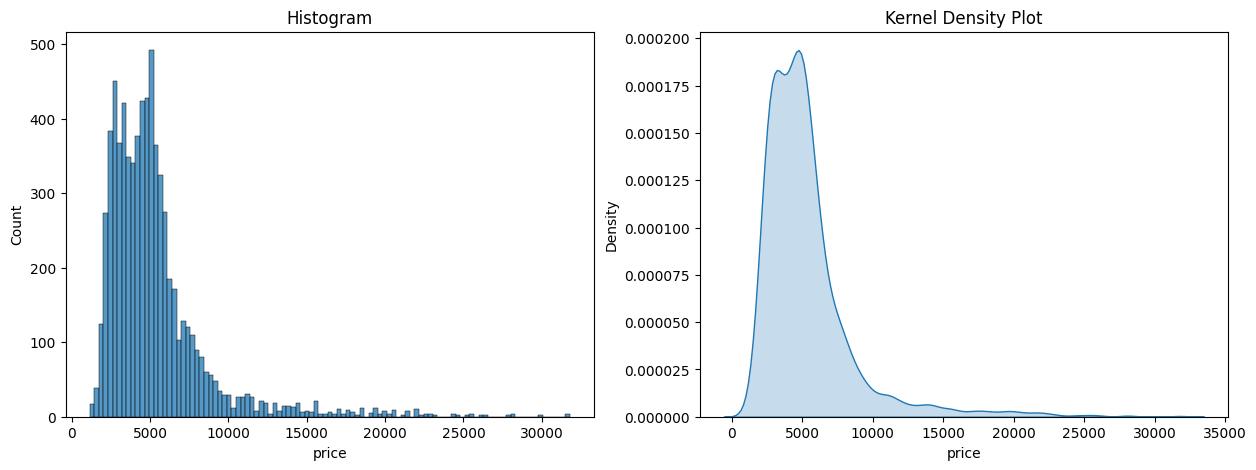

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))

sns.histplot(data=df, x='price', kde=False, ax=ax1)
ax1.set_title('Histogram')

sns.kdeplot(data=df, x='price', fill=True, ax=ax2)
ax2.set_title('Kernel Density Plot')

plt.show()

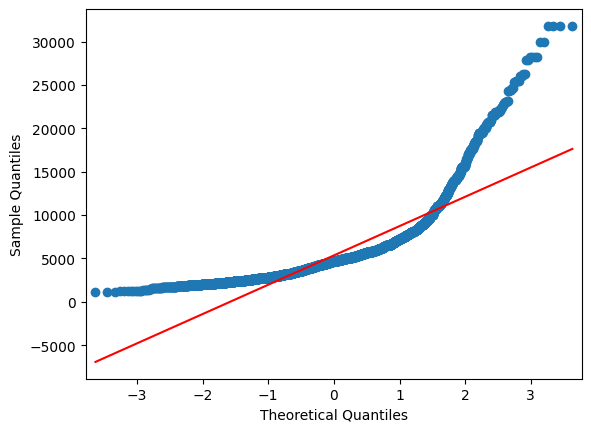

In [ ]:
from statsmodels.graphics.gofplots import qqplot

qqplot(df['price'], line='s')
plt.show()

In [ ]:
from scipy.stats import shapiro

stat, p = shapiro(df['price'])
print(f'Shapiro-Wilk test: stat={round(stat, 2)}, p={round(p, 2)}')

Shapiro-Wilk test: stat=0.74, p=0.0


/usr/local/lib/python3.9/dist-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [ ]:
df = pd.DataFrame(notebook_data)
top_systems = df['System operacyjny:'].value_counts()[:6].index.tolist()
df['System operacyjny:'] = np.where(df['System operacyjny:'].isin(top_systems), df['System operacyjny:'], 'other_system')

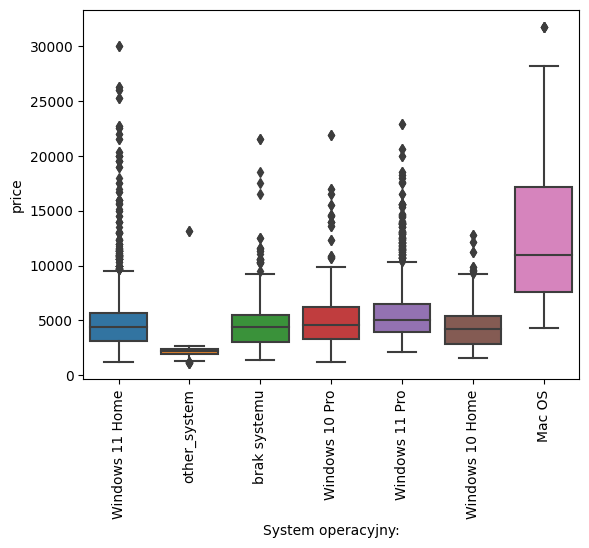

In [ ]:
sns.boxplot(x="System operacyjny:", y="price", data=df)
plt.xticks(rotation=90)
plt.show()

In [ ]:
df = pd.DataFrame(notebook_data)
df['System operacyjny:'] = df['System operacyjny:'].map(lambda x: 'Windows' if x.lower().startswith('windows') else x)

In [ ]:
df['System operacyjny:'].value_counts()

Windows         5304
brak systemu    1501
Mac OS           338
Chrome OS          9
Linux              2
Name: System operacyjny:, dtype: int64

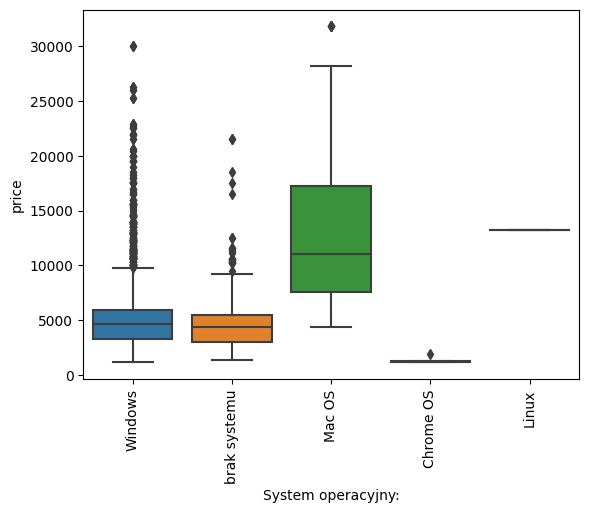

In [ ]:
sns.boxplot(x="System operacyjny:", y="price", data=df)
plt.xticks(rotation=90)
plt.show()

In [ ]:
df = pd.DataFrame(notebook_data)

df1 = df.copy()
df2 = df.copy()

top_ram = df1['Wielkość pamięci RAM:'].value_counts()[:5].index.tolist()

df1['Wielkość pamięci RAM:'] = np.where(df1['Wielkość pamięci RAM:'].isin(top_ram), df1['Wielkość pamięci RAM:'], 'other_ram')
df2['Wielkość pamięci RAM:'] = df2['Wielkość pamięci RAM:'].str.split(' ').map(lambda x: x[0]).astype(int)

In [ ]:
df1['Wielkość pamięci RAM:'].value_counts()

16 GB        3326
8 GB         1783
32 GB        1512
12 GB         286
other_ram     151
64 GB          96
Name: Wielkość pamięci RAM:, dtype: int64

In [ ]:
df2['Wielkość pamięci RAM:'].value_counts()

16    3326
8     1783
32    1512
12     286
64      96
4       85
24      54
96      10
40       2
Name: Wielkość pamięci RAM:, dtype: int64

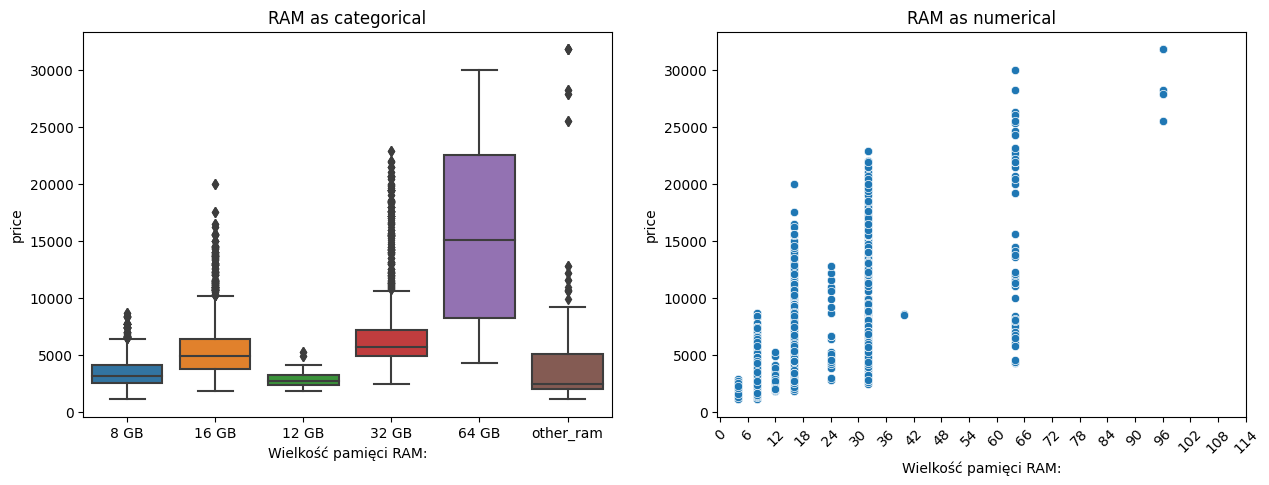

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))

sns.boxplot(x="Wielkość pamięci RAM:", y="price", data=df1, ax=ax1)
plt.xticks(rotation=90)
ax1.set_title('RAM as categorical')

sns.scatterplot(x="Wielkość pamięci RAM:", y="price", data=df2)
plt.xticks(range(0, 120, 6),
           rotation=45)
ax2.set_title('RAM as numerical')

plt.show()

In [ ]:
df = pd.DataFrame(notebook_data)

df1 = df.copy()
df2 = df.copy()

top_ssd = df1['Pojemność dysku SSD:'].value_counts()[:5].index.tolist()

df1['Pojemność dysku SSD:'] = np.where(df1['Pojemność dysku SSD:'].isin(top_ssd), df1['Pojemność dysku SSD:'], 'other_hardware')

most_common_ssd = df2['Pojemność dysku SSD:'].value_counts().head().index[0]
df2['Pojemność dysku SSD:'].fillna(most_common_ssd, inplace=True)
df2['Pojemność dysku SSD:'] = df2['Pojemność dysku SSD:'].apply(lambda x: x.split(' ')[0]).astype(int)


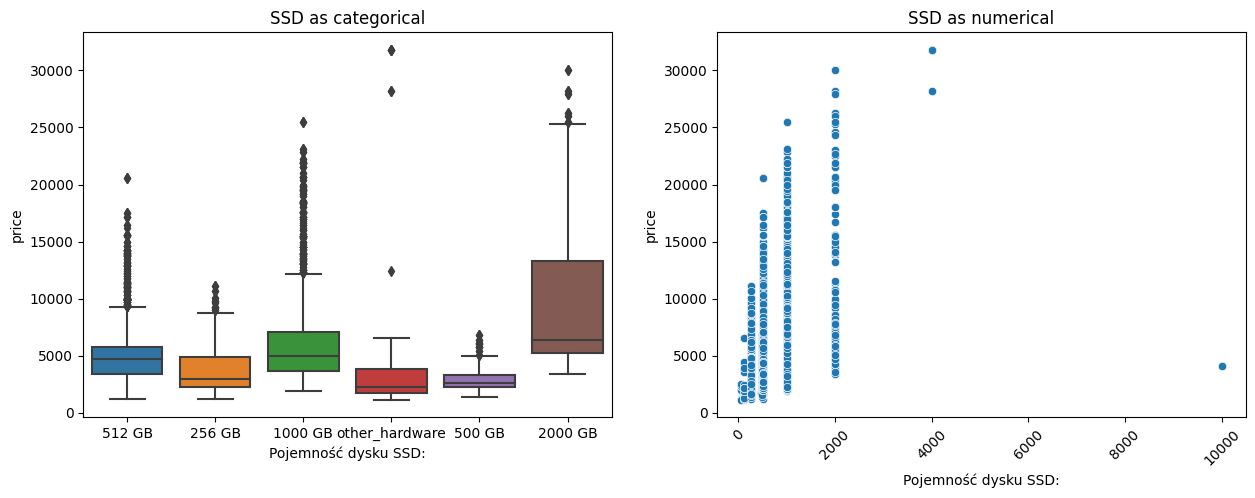

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))

sns.boxplot(x="Pojemność dysku SSD:", y="price", data=df1, ax=ax1)
plt.xticks(rotation=90)
ax1.set_title('SSD as categorical')

sns.scatterplot(x="Pojemność dysku SSD:", y="price", data=df2)
plt.xticks(rotation=45)
ax2.set_title('SSD as numerical')

plt.show()

In [ ]:
df2['Pojemność dysku SSD:'].value_counts()

In [ ]:
ssd_threshold = 4000
price_threshold = np.percentile(df['price'], 75)
conditions = (df2['Pojemność dysku SSD:'] > ssd_threshold) & (df2['price'] < price_threshold)
df2.drop(index=df2[conditions].index, inplace=True)

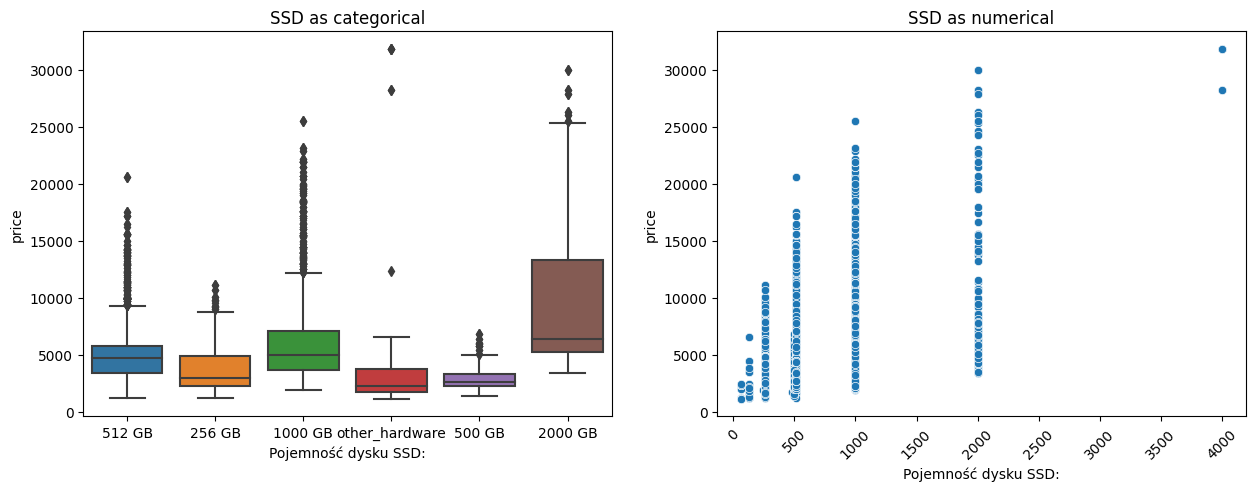

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))

sns.boxplot(x="Pojemność dysku SSD:", y="price", data=df1, ax=ax1)
plt.xticks(rotation=90)
ax1.set_title('SSD as categorical')

sns.scatterplot(x="Pojemność dysku SSD:", y="price", data=df2)
plt.xticks(rotation=45)
ax2.set_title('SSD as numerical')

plt.show()

In [ ]:
# df = pd.DataFrame(notebook_data)

# df2 = df.copy()

# df2['Wielkość pamięci RAM:'] = df2['Wielkość pamięci RAM:'].str.split(' ').map(lambda x: x[0]).astype(int)

# most_common_ssd = df2['Pojemność dysku SSD:'].value_counts().head().index[0]
# df2['Pojemność dysku SSD:'].fillna(most_common_ssd, inplace=True)
# df2['Pojemność dysku SSD:'] = df2['Pojemność dysku SSD:'].apply(lambda x: x.split(' ')[0]).astype(int)
# ssd_threshold = 4000
# price_threshold = np.percentile(df['price'], 75)
# conditions = (df2['Pojemność dysku SSD:'] > ssd_threshold) & (df2['price'] < price_threshold)
# df2.drop(index=df2[conditions].index, inplace=True)

In [ ]:
df.info()

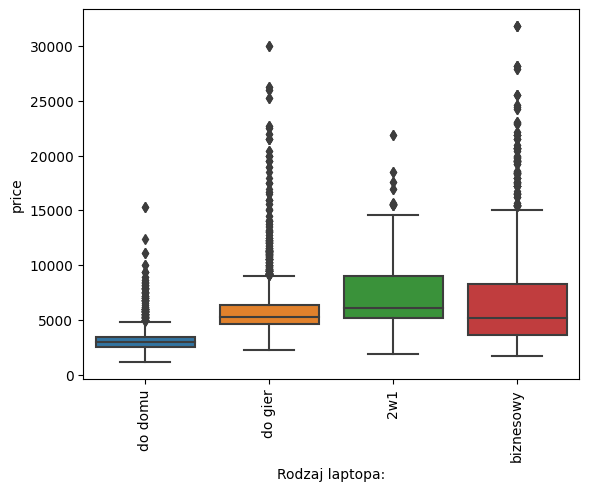

In [ ]:
df = pd.DataFrame(notebook_data)

df2 = df.copy()

sns.boxplot(x="Rodzaj laptopa:", y="price", data=df2)
plt.xticks(rotation=90)

plt.show()





#Predictive models for categorical independent variables

Given the following results, which show the accuracy of the linear regression model at 52.1% and the decision tree at 64.9%, and the fact that the model can be wrong by almost 1,300 zlotys (25% of the price) on a laptop, it was decided to treat the added resolution value and present RAM and SSD capacity as numerical data to assess their impact on the model. 

##Clear and scale

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree

In [ ]:
df = pd.DataFrame(notebook_data)

In [ ]:
X = df[['System operacyjny:', 'Wielkość pamięci RAM:', 'Pojemność dysku SSD:']]
y = df[['price']]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42) # zwraca tupla z czterema elementami 

In [ ]:
X_train['System operacyjny:'] = np.where(X_train['System operacyjny:'].isin(X_train['System operacyjny:'].value_counts()[:6].index.tolist()), X_train['System operacyjny:'], 'other_system')
X_train['Wielkość pamięci RAM:'] = np.where(X_train['Wielkość pamięci RAM:'].isin(X_train['Wielkość pamięci RAM:'].value_counts()[:5].index.tolist()), X_train['Wielkość pamięci RAM:'], 'other_ram')
X_train['Pojemność dysku SSD:'] = np.where(X_train['Pojemność dysku SSD:'].isin(X_train['Pojemność dysku SSD:'].value_counts()[:5].index.tolist()), X_train['Pojemność dysku SSD:'], 'other_hardware')

In [ ]:
scaler = StandardScaler()
ohe = OneHotEncoder(sparse_output=False)

In [ ]:
scaled_y  = scaler.fit_transform(y_train) #PAMIĘTAJ NIE DAWAJ FITA POTEM NA TESTOWYM!!!!
encoded_x = ohe.fit_transform(X_train)

##Linear Regression

In [ ]:
linear_pipeline = Pipeline([
    ('polynomial', PolynomialFeatures()),
    ('linear', LinearRegression())
      ])

linear_params = {'polynomial__degree': [1, 2, 3]}

In [ ]:
linear_grid = GridSearchCV(linear_pipeline,
                           param_grid=linear_params, 
                           cv=10)

In [ ]:
linear_grid.fit(encoded_x, scaled_y)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('polynomial', PolynomialFeatures()),
                                       ('linear', LinearRegression())]),
             param_grid={'polynomial__degree': [1, 2, 3]})

In [ ]:
linear_grid.best_score_

0.5215566181980084

In [ ]:
linear_grid.best_params_

##Decision Tree

In [ ]:
dtr = DecisionTreeRegressor()

tree_params = {'max_depth': np.arange(1, 30),
          'min_samples_split': [2, 4, 6, 8, 10],
          'min_samples_leaf': [1, 3, 5, 7, 9]}

In [ ]:
tree_grid = GridSearchCV(dtr,
                         param_grid=tree_params,
                         verbose=4,
                         cv=10)

In [ ]:
tree_grid.fit(encoded_x, y_train)

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
[CV 1/10] END max_depth=10, min_samples_leaf=1, min_samples_split=2;, score=0.697 total time=   0.0s
[CV 2/10] END max_depth=10, min_samples_leaf=1, min_samples_split=2;, score=0.639 total time=   0.0s
[CV 3/10] END max_depth=10, min_samples_leaf=1, min_samples_split=2;, score=0.704 total time=   0.0s
[CV 4/10] END max_depth=10, min_samples_leaf=1, min_samples_split=2;, score=0.567 total time=   0.0s
[CV 5/10] END max_depth=10, min_samples_leaf=1, min_samples_split=2;, score=0.703 total time=   0.0s
[CV 6/10] END max_depth=10, min_samples_leaf=1, min_samples_split=2;, score=0.640 total time=   0.0s
[CV 7/10] END max_depth=10, min_samples_leaf=1, min_samples_split=2;, score=0.598 total time=   0.0s
[CV 8/10] END max_depth=10, min_samples_leaf=1, min_samples_split=2;, score=0.589 total time=   0.0s
[CV 9/10] END max_depth=10, min_samples_leaf=1, min_samples_split=2;, score=0.582 total time=   0.0s
[CV 10/10] END max_depth=1

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
                         'min_samples_leaf': [1, 3, 5, 7, 9],
                         'min_samples_split': [2, 4, 6, 8, 10]},
             verbose=4)

In [ ]:
tree_grid.best_score_

0.6409434730936978

In [ ]:
tree_grid.best_params_

In [ ]:
#NIE TYKAĆ 
# linear_pred = linear_grid.predict(X_test)
# tree_pred = tree_grid.predict(X_test)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
print(mean_absolute_error(y_train, tree_grid.predict(encoded_x)))
print(mean_absolute_percentage_error(y_train, tree_grid.predict(encoded_x)))
print(mean_squared_error(y_train, tree_grid.predict(encoded_x)))

#Predictive models for categorical and numerical independent variables

The decision to transform the data into numeric values and include resolution resulted in an increase in model efficiency (R^2 = 76%), indicating that the laptop price prediction could be off by approximately 1078 Polish złoty (about 22.6%). However, these values still require further improvement of the model. It has been decided to obtain data on graphics card performance, as this characteristic has the highest impact on the price of the unit according to our preliminary analysis. Due to the large number of categories, it is necessary to assign some numerical values to them, as using one-hot encoding would result in too many columns. However, reducing the categories, for example, to 10 where 9 of them will be the most frequent values and the 10th category will be 'others', would oversimplify and omit important graphics card models.

##Clear and scale

In [ ]:
df = pd.DataFrame(notebook_data)

In [ ]:
X = df[['System operacyjny:', 'Wielkość pamięci RAM:', 'Pojemność dysku SSD:', 'Rozdzielczość:']]
y = df[['price']]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42) # zwraca tupla z czterema elementami 

In [ ]:
X_train['System operacyjny:'] = X_train['System operacyjny:'].map(lambda x: 'Windows' if x.lower().startswith('windows') else x)
X_train['Wielkość pamięci RAM:'] = X_train['Wielkość pamięci RAM:'].str.split(' ').map(lambda x: x[0]).astype(int)

most_common_ssd = X_train['Pojemność dysku SSD:'].value_counts().head().index[0]
X_train['Pojemność dysku SSD:'].fillna(most_common_ssd, inplace=True)
X_train['Pojemność dysku SSD:'] = X_train['Pojemność dysku SSD:'].apply(lambda x: x.split(' ')[0]).astype(int)
ssd_threshold = 4000
price_threshold = np.percentile(y_train, 75)
merged_train = pd.concat([X_train, y_train], axis=1)
filtered_df = merged_train[(merged_train['Pojemność dysku SSD:'] > ssd_threshold) & (merged_train['price'] < price_threshold)].index
X_train.drop(index=filtered_df, axis=0, inplace=True)
y_train.drop(index=filtered_df, axis=0, inplace=True)

most_common = X_train['Rozdzielczość:'].value_counts().index[0]
X_train['Rozdzielczość:'] = X_train['Rozdzielczość:'].fillna(most_common)
X_train['Rozdzielczość:'] = X_train['Rozdzielczość:'].map(lambda x: int(str(x).split('x')[0]) * int(str(x).split('x')[1].strip()[:4]))

In [ ]:
profile_df = X_train.copy()
profile_df['price'] = y_train.copy()
prof = ProfileReport(profile_df, infer_dtypes=False)
prof

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


KeyboardInterrupt



In [ ]:
scaler_x = StandardScaler()
scaler_y = StandardScaler()
ohe = OneHotEncoder(sparse_output=False)

In [ ]:
x_scaled = scaler_x.fit_transform(X_train.select_dtypes(exclude='object')) 
x_encoded = ohe.fit_transform(X_train.select_dtypes(include='object'))
y_scaled = scaler_y.fit_transform(y_train) #PAMIĘTAJ O SCALERZE oddzielnie dla x i y

In [ ]:
processed_data = np.concatenate([x_scaled, x_encoded], axis=1)

##Linear Regression

In [ ]:
linear_pipeline = Pipeline([
    ('polynomial', PolynomialFeatures()),
    ('linear', LinearRegression())
      ])

linear_params = {'polynomial__degree': [1, 2, 3]}

In [ ]:
linear_grid = GridSearchCV(linear_pipeline,
                           param_grid=linear_params, 
                           cv=10)

In [ ]:
linear_grid.fit(processed_data, y_scaled)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('polynomial', PolynomialFeatures()),
                                       ('linear', LinearRegression())]),
             param_grid={'polynomial__degree': [1, 2, 3]})

In [ ]:
linear_grid.best_score_

0.6596484231294372

##Decision Tree

In [ ]:
dtr = DecisionTreeRegressor()

tree_params = {'max_depth': np.arange(1, 30),
          'min_samples_split': [2, 4, 6, 8, 10],
          'min_samples_leaf': [1, 3, 5, 7, 9]}

In [ ]:
tree_grid = GridSearchCV(dtr,
                         param_grid=tree_params,
                         verbose=4,
                         cv=10)

In [ ]:
tree_grid.fit(processed_data, y_train)

In [ ]:
tree_grid.best_score_

0.7634120100314741

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
print(mean_absolute_error(y_train, tree_grid.predict(processed_data)))
print(mean_absolute_percentage_error(y_train, tree_grid.predict(processed_data)))
print(mean_squared_error(y_train, tree_grid.predict(processed_data)))

1078.3784914501357
0.22620792331586395
2416460.15967594


#Predictive models for categorical and numerical independent variables with GPU benchmark scores

Based on the analysis of the initial correlation of dependencies, it was decided to enrich the model with benchmark scores for graphics cards representing specific laptop models. This data allowed to improve the performance of the model to R^2= 90.0% for the decision tree model, while the linear model reached 68.1%. Thus, a level was reached where the model was wrong on average by 12% on the price of one unit (about PLN 580). Although this is a satisfactory level, the available data also allow to try to improve the performance of the model by adding such independent variables as the presence of a second and third SSD and whether the device has a backlit keyboard.


##Clear and scale

In [ ]:
df = pd.DataFrame(notebook_data)

In [ ]:
X = df[['System operacyjny:', 'Wielkość pamięci RAM:', 'Pojemność dysku SSD:', 'Rozdzielczość:', 'Karta graficzna:']]
y = df[['price']]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42) # zwraca tupla z czterema elementami 

In [ ]:
X_train['System operacyjny:'] = X_train['System operacyjny:'].map(lambda x: 'Windows' if x.lower().startswith('windows') else x)
X_train['Wielkość pamięci RAM:'] = X_train['Wielkość pamięci RAM:'].str.split(' ').map(lambda x: x[0]).astype(int)

most_common_ssd = X_train['Pojemność dysku SSD:'].value_counts().head().index[0]
X_train['Pojemność dysku SSD:'].fillna(most_common_ssd, inplace=True)
X_train['Pojemność dysku SSD:'] = X_train['Pojemność dysku SSD:'].apply(lambda x: x.split(' ')[0]).astype(int)
ssd_threshold = 4000
price_threshold = np.percentile(y_train, 75)
merged_train = pd.concat([X_train, y_train], axis=1)
filtered_df = merged_train[(merged_train['Pojemność dysku SSD:'] > ssd_threshold) & (merged_train['price'] < price_threshold)].index
X_train.drop(index=filtered_df, axis=0, inplace=True)
y_train.drop(index=filtered_df, axis=0, inplace=True)

most_common = X_train['Rozdzielczość:'].value_counts().index[0]
X_train['Rozdzielczość:'] = X_train['Rozdzielczość:'].fillna(most_common)
X_train['Rozdzielczość:'] = X_train['Rozdzielczość:'].map(lambda x: int(str(x).split('x')[0]) * int(str(x).split('x')[1].strip()[:4]))

top_cat = X_train['Karta graficzna:'].value_counts()[0]
X_train['Karta graficzna:'] = X_train['Karta graficzna:'].fillna(top_cat)

In [ ]:
from fuzzywuzzy import fuzz

url = 'https://browser.geekbench.com/opencl-benchmarks'

response = requests.get(url)
content = response.content
soup = BeautifulSoup(content, 'html.parser')

gpu_scores = {}
gpus = []
scores = []
for item in soup.find_all('table', {'class': 'table benchmark-chart-table'}):
  for gpu in soup.find_all('td', {'class': 'name'}):
    gpus.append(gpu.text.strip())
  for score in soup.find_all('td', {'class': 'score'}):
    scores.append(int(score.text))

for i in range(0, len(gpus)):
  gpu_scores[gpus[i]] = scores[i]

print(gpu_scores)

list_of_gpus = X_train['Karta graficzna:'].unique().tolist()
print(type(list_of_gpus[0]), list_of_gpus[0])
from fuzzywuzzy import fuzz


# find the best matching GPU name in the dictionary for each GPU name in the list
matches = {}
matched_gpus = {}
for gpu_name in list_of_gpus:
  best_match = None
  best_score = 0
  for name in gpu_scores.keys():
    score = fuzz.ratio(name, str(gpu_name))
    if score > best_score:
      best_match = gpu_name
      best_score = score
      best_value = gpu_scores[name]
  matches[gpu_name] = best_match
  matched_gpus[best_match] = best_value

{'NVIDIA GeForce RTX 4090': 326714, 'NVIDIA RTX 6000 Ada Generation': 312956, 'NVIDIA GeForce RTX 4080': 245574, 'NVIDIA A100 80GB PCIe': 214586, 'GeForce RTX 3080 Ti': 209081, 'NVIDIA GeForce RTX 4070 Ti': 208891, 'NVIDIA A100-PCIE-80GB': 207124, 'NVIDIA GeForce RTX 3090 Ti': 206125, 'RTX A6000': 200330, 'AMD Radeon RX 7900 XTX': 198076, 'GRID A100-7-40C MIG 7g.40gb': 196825, 'NVIDIA GeForce RTX 3090': 196462, 'GeForce RTX 3090': 194242, 'NVIDIA GeForce RTX 3080 Ti': 193653, 'NVIDIA RTX A6000': 192902, 'NVIDIA A40': 190604, 'NVIDIA GeForce RTX 4090 Laptop GPU': 180741, 'GeForce RTX 3080': 178807, 'AMD Radeon RX 7900 XT': 178576, 'NVIDIA A40-12Q': 174796, 'NVIDIA GeForce RTX 3080': 174287, 'AMD Radeon RX 6950 XT': 174227, 'NVIDIA A10G': 172506, 'Quadro GV100': 168515, 'RTX A5000': 166307, 'NVIDIA A10': 164387, 'NVIDIA GeForce RTX 4080 Laptop GPU': 161219, 'NVIDIA RTX A5000': 160869, 'AMD Radeon RX 6900 XT': 160079, 'RX 6800 XT': 158867, 'A40-12Q': 156643, 'RX6800 XT': 155147, 'GRID V10

In [ ]:
X_train['GPU benchmark:'] = X_train['Karta graficzna:'].map(matched_gpus)

In [ ]:
X_train.drop('Karta graficzna:', axis=1, inplace=True)

In [ ]:
scaler_x = StandardScaler()
scaler_y = StandardScaler()
ohe = OneHotEncoder(sparse_output=False)

In [ ]:
x_scaled = scaler_x.fit_transform(X_train.select_dtypes(exclude='object')) 
x_encoded = ohe.fit_transform(X_train.select_dtypes(include='object'))
y_scaled = scaler_y.fit_transform(y_train) #PAMIĘTAJ O SCALERZE oddzielnie dla x i y

In [ ]:
processed_data = np.concatenate([x_scaled, x_encoded], axis=1)

In [ ]:
profile_df = X_train.copy()
profile_df['price'] = y_train.copy()
prof = ProfileReport(profile_df, infer_dtypes=False)
prof

##Linear Regression

In [ ]:
linear_pipeline = Pipeline([
    ('polynomial', PolynomialFeatures()),
    ('linear', LinearRegression())
      ])

linear_params = {'polynomial__degree': [1, 2, 3]}

In [ ]:
linear_grid = GridSearchCV(linear_pipeline,
                           param_grid=linear_params, 
                           cv=10)

In [ ]:
linear_grid.fit(processed_data, y_scaled)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('polynomial', PolynomialFeatures()),
                                       ('linear', LinearRegression())]),
             param_grid={'polynomial__degree': [1, 2, 3]})

In [ ]:
linear_grid.best_score_

0.6817256144091597

##Decision Tree

In [ ]:
dtr = DecisionTreeRegressor()

tree_params = {'max_depth': np.arange(1, 30),
          'min_samples_split': [2, 4, 6, 8, 10],
          'min_samples_leaf': [1, 3, 5, 7, 9]}

In [ ]:
tree_grid = GridSearchCV(dtr,
                         param_grid=tree_params,
                         verbose=4,
                         cv=10)

In [ ]:
tree_grid.fit(processed_data, y_train)

In [ ]:
tree_grid.best_score_

0.9020354684839684

In [ ]:
tree_grid.best_params_

{'max_depth': 26, 'min_samples_leaf': 1, 'min_samples_split': 2}

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
print(mean_absolute_error(y_train, tree_grid.predict(processed_data)))
print(mean_absolute_percentage_error(y_train, tree_grid.predict(processed_data)))
print(mean_squared_error(y_train, tree_grid.predict(processed_data)))

542.2847176803028
0.11772108182024917
793429.9312127213


#Predictive models for categorical and numerical independent variables with GPU benchmark scores, presence of additional SSDs and whether the keyboard is backlit.

Preliminary analysis showed that the Information on whether the laptop has a backlit keyboard and/or a second ssd drive will affect the price. Accordingly, an attempt was made to fine-tune the model with these two additional pieces of information. The results showed a slight improvement, with the decision tree reaching an error rate of 10.7% (PLN 490 per unit).

##Clear and scale

In [ ]:
df = pd.DataFrame(notebook_data)

In [ ]:
df.sample(5)

In [ ]:
X = df[['System operacyjny:', 'Wielkość pamięci RAM:', 'Pojemność dysku SSD:', 'Rozdzielczość:', 'Karta graficzna:', 'Pojemność dysku SSD 2:', 'Podświetlana klawiatura:']]
y = df[['price']]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42) # zwraca tupla z czterema elementami 

In [ ]:
X_train.info()

In [ ]:
X_train['System operacyjny:'] = X_train['System operacyjny:'].map(lambda x: 'Windows' if x.lower().startswith('windows') else x)
X_train['Wielkość pamięci RAM:'] = X_train['Wielkość pamięci RAM:'].str.split(' ').map(lambda x: x[0]).astype(int)

most_common_ssd = X_train['Pojemność dysku SSD:'].value_counts().head().index[0]
X_train['Pojemność dysku SSD:'].fillna(most_common_ssd, inplace=True)
X_train['Pojemność dysku SSD:'] = X_train['Pojemność dysku SSD:'].apply(lambda x: x.split(' ')[0]).astype(int)
ssd_threshold = 4000
price_threshold = np.percentile(y_train, 75)
merged_train = pd.concat([X_train, y_train], axis=1)
filtered_df = merged_train[(merged_train['Pojemność dysku SSD:'] > ssd_threshold) & (merged_train['price'] < price_threshold)].index
X_train.drop(index=filtered_df, axis=0, inplace=True)
y_train.drop(index=filtered_df, axis=0, inplace=True)

most_common = X_train['Rozdzielczość:'].value_counts().index[0]
X_train['Rozdzielczość:'] = X_train['Rozdzielczość:'].fillna(most_common)
X_train['Rozdzielczość:'] = X_train['Rozdzielczość:'].map(lambda x: int(str(x).split('x')[0]) * int(str(x).split('x')[1].strip()[:4]))

top_cat = X_train['Karta graficzna:'].value_counts()[0]
X_train['Karta graficzna:'] = X_train['Karta graficzna:'].fillna(top_cat)

X_train['Pojemność dysku SSD 2:'] = np.where(X_train['Pojemność dysku SSD 2:'].isnull(), False, True)
X_train['Podświetlana klawiatura:'] = np.where(X_train['Podświetlana klawiatura:'] == 'tak', True, False)

In [ ]:
X_train.info()

In [ ]:
url = 'https://browser.geekbench.com/opencl-benchmarks'

response = requests.get(url)
content = response.content
soup = BeautifulSoup(content, 'html.parser')

gpu_scores = {}
gpus = []
scores = []
for item in soup.find_all('table', {'class': 'table benchmark-chart-table'}):
  for gpu in soup.find_all('td', {'class': 'name'}):
    gpus.append(gpu.text.strip())
  for score in soup.find_all('td', {'class': 'score'}):
    scores.append(int(score.text))

for i in range(0, len(gpus)):
  gpu_scores[gpus[i]] = scores[i]

print(gpu_scores)

list_of_gpus = X_train['Karta graficzna:'].unique().tolist()
print(type(list_of_gpus[0]), list_of_gpus[0])

# find the best matching GPU name in the dictionary for each GPU name in the list
matches = {}
matched_gpus = {}
for gpu_name in list_of_gpus:
  best_match = None
  best_score = 0
  for name in gpu_scores.keys():
    score = fuzz.ratio(name, str(gpu_name))
    if score > best_score:
      best_match = gpu_name
      best_score = score
      best_value = gpu_scores[name]
  matches[gpu_name] = best_match
  matched_gpus[best_match] = best_value

{'NVIDIA GeForce RTX 4090': 326714, 'NVIDIA RTX 6000 Ada Generation': 312956, 'NVIDIA GeForce RTX 4080': 245574, 'NVIDIA A100 80GB PCIe': 214586, 'GeForce RTX 3080 Ti': 209081, 'NVIDIA GeForce RTX 4070 Ti': 208891, 'NVIDIA A100-PCIE-80GB': 207124, 'NVIDIA GeForce RTX 3090 Ti': 206125, 'RTX A6000': 200330, 'AMD Radeon RX 7900 XTX': 198076, 'GRID A100-7-40C MIG 7g.40gb': 196825, 'NVIDIA GeForce RTX 3090': 196462, 'GeForce RTX 3090': 194242, 'NVIDIA GeForce RTX 3080 Ti': 193653, 'NVIDIA RTX A6000': 192902, 'NVIDIA A40': 190604, 'NVIDIA GeForce RTX 4090 Laptop GPU': 180741, 'GeForce RTX 3080': 178807, 'AMD Radeon RX 7900 XT': 178576, 'NVIDIA A40-12Q': 174796, 'NVIDIA GeForce RTX 3080': 174287, 'AMD Radeon RX 6950 XT': 174227, 'NVIDIA A10G': 172506, 'Quadro GV100': 168515, 'RTX A5000': 166307, 'NVIDIA A10': 164387, 'NVIDIA GeForce RTX 4080 Laptop GPU': 161219, 'NVIDIA RTX A5000': 160869, 'AMD Radeon RX 6900 XT': 160079, 'RX 6800 XT': 158867, 'A40-12Q': 156643, 'RX6800 XT': 155147, 'GRID V10

In [ ]:
X_train['GPU benchmark:'] = X_train['Karta graficzna:'].map(matched_gpus)

In [ ]:
X_train.drop('Karta graficzna:', axis=1, inplace=True)

In [ ]:
scaler_x = StandardScaler()
scaler_y = StandardScaler()
ohe = OneHotEncoder(sparse_output=False, drop='first')

In [ ]:
x_scaled = scaler_x.fit_transform(X_train.select_dtypes(exclude=['object', 'bool'])) 
x_encoded = ohe.fit_transform(X_train.select_dtypes(include=['object', 'bool']))
y_scaled = scaler_y.fit_transform(y_train) #PAMIĘTAJ O SCALERZE oddzielnie dla x i y

In [ ]:
pd.DataFrame(x_encoded, columns=ohe.get_feature_names_out())


In [ ]:
processed_data = np.concatenate([x_scaled, x_encoded], axis=1)

In [ ]:
profile_df = X_train.copy()
profile_df['price'] = y_train.copy()
prof = ProfileReport(profile_df, infer_dtypes=False)
prof

##Linear Regression

In [ ]:
linear_pipeline = Pipeline([
    ('polynomial', PolynomialFeatures()),
    ('linear', LinearRegression())
      ])

linear_params = {'polynomial__degree': [1, 2, 3]}

In [ ]:
linear_grid = GridSearchCV(linear_pipeline,
                           param_grid=linear_params, 
                           cv=10)

In [ ]:
linear_grid.fit(processed_data, y_scaled)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('polynomial', PolynomialFeatures()),
                                       ('linear', LinearRegression())]),
             param_grid={'polynomial__degree': [1, 2, 3]})

In [ ]:
linear_grid.best_score_

0.7445610000415883

##Decision Tree

In [ ]:
dtr = DecisionTreeRegressor()

tree_params = {'max_depth': np.arange(1, 30),
          'min_samples_split': [2, 4, 6, 8, 10],
          'min_samples_leaf': [1, 3, 5, 7, 9]}

In [ ]:
tree_grid = GridSearchCV(dtr,
                         param_grid=tree_params,
                         verbose=4,
                         cv=10)

In [ ]:
tree_grid.fit(processed_data, y_train)

In [ ]:
tree_grid.best_score_

0.8983570115918169

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
print(mean_absolute_error(y_train, tree_grid.predict(processed_data)))
print(mean_absolute_percentage_error(y_train, tree_grid.predict(processed_data)))

490.8283794180611
0.10676592039677966


In [ ]:
tree_grid.best_estimator_.feature_importances_ #wagi wszystkich cech, które były istotne

array([0.10368939, 0.02417551, 0.60119965, 0.24749881, 0.        ,
       0.00427457, 0.00395495, 0.00421379, 0.00365856, 0.00733478])

In [ ]:
scaler_x.get_feature_names_out()

array(['Wielkość pamięci RAM:', 'Pojemność dysku SSD:', 'Rozdzielczość:',
       'GPU benchmark:'], dtype=object)

In [ ]:
ohe.get_feature_names_out()

array(['System operacyjny:_Linux', 'System operacyjny:_Mac OS',
       'System operacyjny:_Windows', 'System operacyjny:_brak systemu',
       'Pojemność dysku SSD 2:_True', 'Podświetlana klawiatura:_True'],
      dtype=object)

In [ ]:
np.concatenate([scaler_x.get_feature_names_out(), ohe.get_feature_names_out()])

array(['Wielkość pamięci RAM:', 'Pojemność dysku SSD:', 'Rozdzielczość:',
       'GPU benchmark:', 'System operacyjny:_Linux',
       'System operacyjny:_Mac OS', 'System operacyjny:_Windows',
       'System operacyjny:_brak systemu', 'Pojemność dysku SSD 2:_True',
       'Podświetlana klawiatura:_True'], dtype=object)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'Wielkość pamięci RAM:'),
  Text(1, 0, 'Pojemność dysku SSD:'),
  Text(2, 0, 'Rozdzielczość:'),
  Text(3, 0, 'GPU benchmark:'),
  Text(4, 0, 'System operacyjny:_Linux'),
  Text(5, 0, 'System operacyjny:_Mac OS'),
  Text(6, 0, 'System operacyjny:_Windows'),
  Text(7, 0, 'System operacyjny:_brak systemu'),
  Text(8, 0, 'Pojemność dysku SSD 2:_True'),
  Text(9, 0, 'Podświetlana klawiatura:_True')])

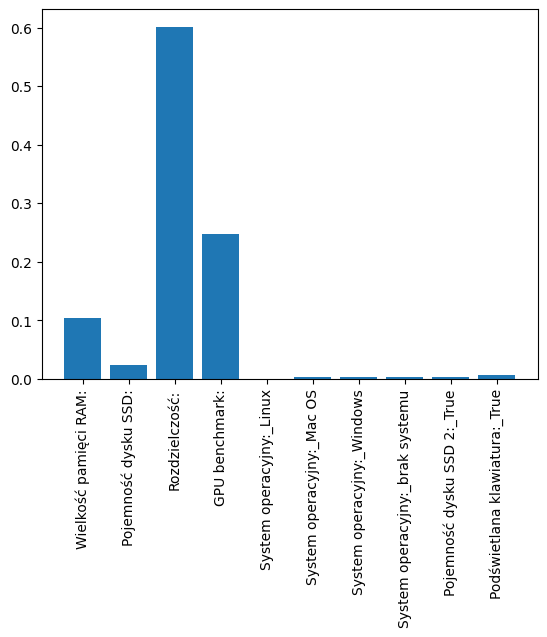

In [ ]:
x_bar = np.concatenate([scaler_x.get_feature_names_out(), ohe.get_feature_names_out()])
y_bar = tree_grid.best_estimator_.feature_importances_
plt.bar(x_bar, 
        y_bar)

plt.xticks(rotation=90)

#Predictive models for categorical and numerical independent variables with a laptop type feature.

As shown in the data analysis, there is a correlation between the price and the type of laptop. Due to the fact that "home" laptops have an average price lower than the others, this gives a significant information to the model to improve its performance. 

##Clear and scale

In [ ]:
df = pd.DataFrame(notebook_data)

In [ ]:
df.sample(5)

In [ ]:
df['Rodzaj laptopa:'].isnull().sum()

5

In [ ]:
X = df[['System operacyjny:', 'Wielkość pamięci RAM:', 'Pojemność dysku SSD:', 'Rozdzielczość:', 'Karta graficzna:', 'Pojemność dysku SSD 2:', 'Podświetlana klawiatura:', 'Rodzaj laptopa:']]
y = df[['price']]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42) # zwraca tupla z czterema elementami 

In [ ]:
X_train.info()

In [ ]:
X_train['System operacyjny:'] = X_train['System operacyjny:'].map(lambda x: 'Windows' if x.lower().startswith('windows') else x)
X_train['Wielkość pamięci RAM:'] = X_train['Wielkość pamięci RAM:'].str.split(' ').map(lambda x: x[0]).astype(int)

most_common_ssd = X_train['Pojemność dysku SSD:'].value_counts().head().index[0]
X_train['Pojemność dysku SSD:'].fillna(most_common_ssd, inplace=True)
X_train['Pojemność dysku SSD:'] = X_train['Pojemność dysku SSD:'].apply(lambda x: x.split(' ')[0]).astype(int)
ssd_threshold = 4000
price_threshold = np.percentile(y_train, 75)
merged_train = pd.concat([X_train, y_train], axis=1)
filtered_df = merged_train[(merged_train['Pojemność dysku SSD:'] > ssd_threshold) & (merged_train['price'] < price_threshold)].index
X_train.drop(index=filtered_df, axis=0, inplace=True)
y_train.drop(index=filtered_df, axis=0, inplace=True)

most_common = X_train['Rozdzielczość:'].value_counts().index[0]
X_train['Rozdzielczość:'] = X_train['Rozdzielczość:'].fillna(most_common)
X_train['Rozdzielczość:'] = X_train['Rozdzielczość:'].map(lambda x: int(str(x).split('x')[0]) * int(str(x).split('x')[1].strip()[:4]))

top_cat = X_train['Karta graficzna:'].value_counts()[0]
X_train['Karta graficzna:'] = X_train['Karta graficzna:'].fillna(top_cat)

X_train['Pojemność dysku SSD 2:'] = np.where(X_train['Pojemność dysku SSD 2:'].isnull(), False, True)
X_train['Podświetlana klawiatura:'] = np.where(X_train['Podświetlana klawiatura:'] == 'tak', True, False)

most_common_type = X_train['Rodzaj laptopa:'].value_counts().head().index[0]
X_train['Rodzaj laptopa:'].fillna(most_common_type, inplace=True)

In [ ]:
X_train.info()

In [ ]:
url = 'https://browser.geekbench.com/opencl-benchmarks'

response = requests.get(url)
content = response.content
soup = BeautifulSoup(content, 'html.parser')

gpu_scores = {}
gpus = []
scores = []
for item in soup.find_all('table', {'class': 'table benchmark-chart-table'}):
  for gpu in soup.find_all('td', {'class': 'name'}):
    gpus.append(gpu.text.strip())
  for score in soup.find_all('td', {'class': 'score'}):
    scores.append(int(score.text))

for i in range(0, len(gpus)):
  gpu_scores[gpus[i]] = scores[i]

print(gpu_scores)

list_of_gpus = X_train['Karta graficzna:'].unique().tolist()
print(type(list_of_gpus[0]), list_of_gpus[0])

# find the best matching GPU name in the dictionary for each GPU name in the list
matches = {}
matched_gpus = {}
for gpu_name in list_of_gpus:
  best_match = None
  best_score = 0
  for name in gpu_scores.keys():
    score = fuzz.ratio(name, str(gpu_name))
    if score > best_score:
      best_match = gpu_name
      best_score = score
      best_value = gpu_scores[name]
  matches[gpu_name] = best_match
  matched_gpus[best_match] = best_value

{'NVIDIA GeForce RTX 4090': 326714, 'NVIDIA RTX 6000 Ada Generation': 312956, 'NVIDIA GeForce RTX 4080': 245574, 'NVIDIA A100 80GB PCIe': 214586, 'GeForce RTX 3080 Ti': 209081, 'NVIDIA GeForce RTX 4070 Ti': 208891, 'NVIDIA A100-PCIE-80GB': 207124, 'NVIDIA GeForce RTX 3090 Ti': 206125, 'RTX A6000': 200330, 'AMD Radeon RX 7900 XTX': 198076, 'GRID A100-7-40C MIG 7g.40gb': 196825, 'NVIDIA GeForce RTX 3090': 196462, 'GeForce RTX 3090': 194242, 'NVIDIA GeForce RTX 3080 Ti': 193653, 'NVIDIA RTX A6000': 192902, 'NVIDIA A40': 190604, 'NVIDIA GeForce RTX 4090 Laptop GPU': 180741, 'GeForce RTX 3080': 178807, 'AMD Radeon RX 7900 XT': 178576, 'NVIDIA A40-12Q': 174796, 'NVIDIA GeForce RTX 3080': 174287, 'AMD Radeon RX 6950 XT': 174227, 'NVIDIA A10G': 172506, 'Quadro GV100': 168515, 'RTX A5000': 166307, 'NVIDIA A10': 164387, 'NVIDIA GeForce RTX 4080 Laptop GPU': 161219, 'NVIDIA RTX A5000': 160869, 'AMD Radeon RX 6900 XT': 160079, 'RX 6800 XT': 158867, 'A40-12Q': 156643, 'RX6800 XT': 155147, 'GRID V10

In [ ]:
X_train['GPU benchmark:'] = X_train['Karta graficzna:'].map(matched_gpus)

In [ ]:
X_train.drop('Karta graficzna:', axis=1, inplace=True)

In [ ]:
scaler_x = StandardScaler()
scaler_y = StandardScaler()
ohe = OneHotEncoder(sparse_output=False, drop='first')

In [ ]:
x_scaled = scaler_x.fit_transform(X_train.select_dtypes(exclude=['object', 'bool'])) 
x_encoded = ohe.fit_transform(X_train.select_dtypes(include=['object', 'bool']))
y_scaled = scaler_y.fit_transform(y_train) #PAMIĘTAJ O SCALERZE oddzielnie dla x i y

In [ ]:
pd.DataFrame(x_encoded, columns=ohe.get_feature_names_out())


In [ ]:
processed_data = np.concatenate([x_scaled, x_encoded], axis=1)

In [ ]:
profile_df = X_train.copy()
profile_df['price'] = y_train.copy()
prof = ProfileReport(profile_df, infer_dtypes=False)
prof

##Linear Regression

In [ ]:
linear_pipeline = Pipeline([
    ('polynomial', PolynomialFeatures()),
    ('linear', LinearRegression())
      ])

linear_params = {'polynomial__degree': [1, 2, 3]}

In [ ]:
linear_grid = GridSearchCV(linear_pipeline,
                           param_grid=linear_params, 
                           cv=10)

In [ ]:
linear_grid.fit(processed_data, y_scaled)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('polynomial', PolynomialFeatures()),
                                       ('linear', LinearRegression())]),
             param_grid={'polynomial__degree': [1, 2, 3]})

In [ ]:
linear_grid.best_score_

0.7207753195286444

##Decision Tree

In [ ]:
dtr = DecisionTreeRegressor()

tree_params = {'max_depth': np.arange(1, 30),
          'min_samples_split': [2, 4, 6, 8, 10],
          'min_samples_leaf': [1, 3, 5, 7, 9]}

In [ ]:
tree_grid = GridSearchCV(dtr,
                         param_grid=tree_params,
                         verbose=4,
                         cv=10)

In [ ]:
tree_grid.fit(processed_data, y_train)

In [ ]:
tree_grid.best_score_

0.9170619471499846

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
print(mean_absolute_error(y_train, tree_grid.predict(processed_data)))
print(mean_absolute_percentage_error(y_train, tree_grid.predict(processed_data)))

428.0319823706748
0.09131652893271472


In [ ]:
tree_grid.best_estimator_.feature_importances_ #wagi wszystkich cech, które były istotne

array([8.87089661e-02, 2.39558910e-02, 5.85356731e-01, 1.67534618e-01,
       4.43282180e-04, 3.10762643e-03, 1.37554713e-03, 2.21199170e-03,
       4.37289898e-03, 7.37365086e-03, 7.24348400e-03, 9.42444483e-02,
       1.40708637e-02])

In [ ]:
scaler_x.get_feature_names_out()

array(['Wielkość pamięci RAM:', 'Pojemność dysku SSD:', 'Rozdzielczość:',
       'GPU benchmark:'], dtype=object)

In [ ]:
ohe.get_feature_names_out()

array(['System operacyjny:_Linux', 'System operacyjny:_Mac OS',
       'System operacyjny:_Windows', 'System operacyjny:_brak systemu',
       'Pojemność dysku SSD 2:_True', 'Podświetlana klawiatura:_True',
       'Rodzaj laptopa:_biznesowy', 'Rodzaj laptopa:_do domu',
       'Rodzaj laptopa:_do gier'], dtype=object)

In [ ]:
np.concatenate([scaler_x.get_feature_names_out(), ohe.get_feature_names_out()])

array(['Wielkość pamięci RAM:', 'Pojemność dysku SSD:', 'Rozdzielczość:',
       'GPU benchmark:', 'System operacyjny:_Linux',
       'System operacyjny:_Mac OS', 'System operacyjny:_Windows',
       'System operacyjny:_brak systemu', 'Pojemność dysku SSD 2:_True',
       'Podświetlana klawiatura:_True', 'Rodzaj laptopa:_biznesowy',
       'Rodzaj laptopa:_do domu', 'Rodzaj laptopa:_do gier'], dtype=object)

In [ ]:
x_bar = np.concatenate([scaler_x.get_feature_names_out(), ohe.get_feature_names_out()])
y_bar = tree_grid.best_estimator_.feature_importances_
plt.bar(x_bar, 
        y_bar)

plt.xticks(rotation=90)